# Inmports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plot import plot_trajectory, plot_errors, plot_time_kinetic_energy
from plasma import cyclotron_xy, ExB_xy

In [2]:
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 16,
    "ytick.labelsize": 15,
    "legend.fontsize": 13
})

## Boris Push and Main Loop

In [3]:
def null_E_field(x, t):
    return np.array([0.0, 0.0, 0.0])

def Ey0(x, t) :
    return np.array([0.0, 1.0, 0.0])

def Bz0(x, t):
    return np.array([0.0, 0.0, 1.0])

In [4]:
def boris_push(x, t, v, q, m, dt, electric_field, magnetic_field):
    """
    Advance velocity v by one full step using Boris scheme.
    x: position at half step (x_{n+1/2})
    t: time at half step (t_{n+1/2})
    v: velocity at time step n
    q, m: charge and mass
    dt: timestep
    """

    E = electric_field(x, t)
    B = magnetic_field(x, t)

    # Half acceleration by E
    v_minus = v + (q * dt / (2 * m)) * E

    # Rotation by B
    t_vec = (q * dt / (2 * m)) * B
    t_mag2 = np.dot(t_vec, t_vec)
    s_vec = 2 * t_vec / (1 + t_mag2)

    v_prime = v_minus + np.cross(v_minus, t_vec)
    v_plus = v_minus + np.cross(v_prime, s_vec)

    # Second half acceleration by E
    v_new = v_plus + (q * dt / (2 * m)) * E

    return v_new

In [5]:
def simulate(x0, v0, q, m, times, dt, electric_field, magnetic_field):
    """
    Simulate a particle trajectory using the Boris scheme.
    Returns arrays of x and v.
    """
    # Initializations
    x_half = x0 + 0.5 * dt * v0   # Leapfrog staggering
    v = v0.copy()

    # Storage
    xs = [x_half]
    vs = [v0]

    for i in range(len(times)-1) :
        # Velocity update (Boris)
        v = boris_push(x_half, times[i], v, q, m, dt, electric_field, magnetic_field)

        # Position update
        x_half = x_half + v * dt

        # Store
        xs.append(x_half.copy())
        vs.append(v.copy())

    return np.array(xs), np.array(vs)


# Plots

In [6]:
def plot_compare(x_num, vs_num, x_an, v_an, step=8, show_arrows=True, title='Numeric (scatter) vs Analytic (line) - xy projection', src="fig.pdf"):
    """
    Plot numeric scatter vs analytic curve (xy-projection), plus velocity arrows.
    x_num: numeric positions shape (N,3)
    vs_num: numeric velocities shape (N,3)
    x_an, v_an: analytic arrays of same shape
    step: sampling period for arrows
    """
    fig, ax = plt.subplots()

    # Numeric scatter
    ax.scatter(x_num[:,0], x_num[:,1], s=20, c='C0', label=r'$x_\mathrm{num}$')

    # Analytic curve
    ax.scatter(x_an[:,0], x_an[:,1], s=20, c='C1', label=r'$x_\mathrm{an}$')

    # initial points markers
    ax.scatter(x_num[0,0], x_num[0,1], marker='o', s=60, facecolors='none', edgecolors='k', label='start')

    if show_arrows:
        # numeric arrows (sampled)
        ax.quiver(
            x_num[::step,0], x_num[::step,1],
            vs_num[::step,0], vs_num[::step,1],
            angles='xy', scale_units='xy', scale=8, width=0.004,
            label=r'$v_{num}$', alpha=0.9
        )
        # analytic arrows (sampled, slightly shifted so they are visible)
        ax.quiver(
            x_an[::step,0], x_an[::step,1],
            v_an[::step,0], v_an[::step,1],
            angles='xy', scale_units='xy', scale=8, width=0.006,
            label=r'$v_\mathrm{an}$', alpha=0.6
        )

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.set_title(title)
    plt.savefig(src, format="pdf", bbox_inches='tight')
    plt.show()
    
def plot_time_kinetic_energy(times, m, vs_num, src="fig.pdf") :
    v_norm = np.linalg.norm(vs_num, axis=1)
    Ek_x = 0.5 * m * vs_num[:,0]**2
    Ek_y = 0.5* m * vs_num[:,1]**2
    Ek_z = 0.5 * m * vs_num[:,2]**2
    Ek_tot = 0.5 * m * v_norm**2
    plt.figure(figsize=(6,4))
    plt.grid()
    plt.plot(times, Ek_x, label=r'$E_{k,x}$')
    plt.plot(times, Ek_y, label=r'$E_{k,y}$')
    plt.plot(times, Ek_z, label=r'$E_{k,z}$')
    plt.plot(times, Ek_tot, label=r"$E_{k, tot}$", color='black')
    plt.xlabel('time')
    plt.title('Kinetic energy vs time')
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    plt.savefig(src, format="pdf", bbox_inches='tight')
    plt.show()

# Physical Parameters

In [7]:
q = -1.0
m = 1.0
B0 = 1.0

omega = q*B0/m
T=2*np.pi/abs(omega)
dt = 0.1
NT = 1
nsteps = int(NT*T/dt)
times = np.linspace(dt/2, nsteps*dt + dt/2, nsteps+1, endpoint=True)

x0 = np.array([1.0, 0.0,0.0])
v0 = np.array([0.0, 1.0, 0.0])

# Cyclotron Motion

In [8]:
x_cyc_num, v_cyc_num = simulate(x0, v0, q, m, times, dt, null_E_field, Bz0)
x_cyc_an, v_cyc_an = cyclotron_xy(x0, v0, q, m, 1.0, times, dt)

## Trajectories

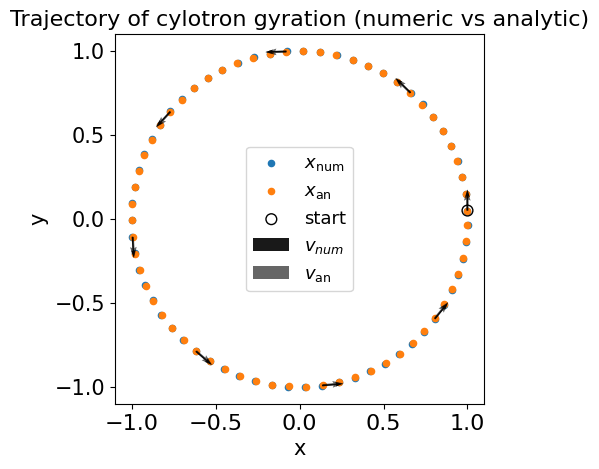

In [9]:
plot_compare(x_cyc_num, v_cyc_num, x_cyc_an, v_cyc_an, step=8, show_arrows=True, title="Trajectory of cylotron gyration (numeric vs analytic)", src="./img/traj_cyc.pdf")

## Kinetic energies

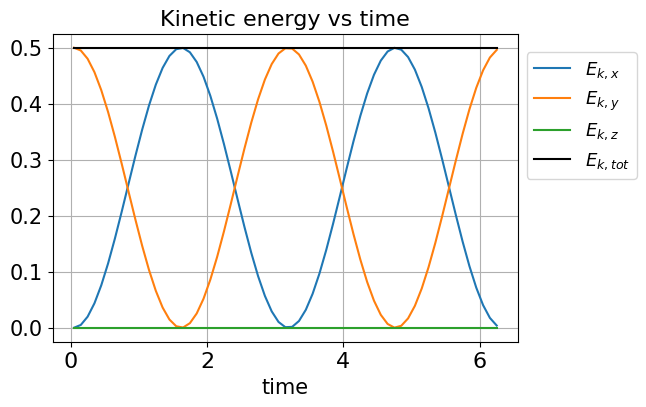

In [10]:
plot_time_kinetic_energy(times, m, v_cyc_num, src="./img/kin_cyc.pdf")

# ExB drift

In [11]:
x_ExB_num, v_ExB_num = simulate(x0, v0, q, m, times, dt, Ey0, Bz0)
x_ExB_an, v_ExB_an = ExB_xy(x0=x0, v0=v0, q=q, m=m, E=[0.0, 1.0, 0.0], B=[0.0, 0.0, 1.0], times=times, dt=dt)

## Trajectories

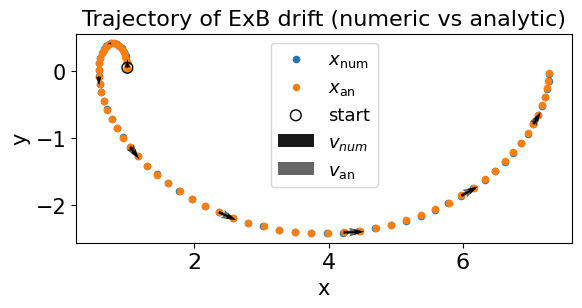

In [12]:
plot_compare(x_ExB_num, v_ExB_num, x_ExB_an, v_ExB_an, step=8, show_arrows=True, title="Trajectory of ExB drift (numeric vs analytic)", src="./img/traj_ExB.pdf")

# Errors

## Error in time

In [13]:
q = -1.0
m = 1.0
B0 = 1.0

omega = q*B0/m
T=2*np.pi/abs(omega)
dt = 0.1
NT = 10
nsteps = int(NT*T/dt)
times = np.linspace(dt/2, nsteps*dt + dt/2, nsteps+1, endpoint=True)

x0 = np.array([1.0, 0.0,0.0])
v0 = np.array([0.0, 1.0, 0.0])

x_cyc_num, v_cyc_num = simulate(x0, v0, q, m, times, dt, null_E_field, Bz0)
x_cyc_an, v_cyc_an = cyclotron_xy(x0, v0, q, m, 1.0, times, dt)
x_ExB_num, v_ExB_num = simulate(x0, v0, q, m, times, dt, Ey0, Bz0)
x_ExB_an, v_ExB_an = ExB_xy(x0=x0, v0=v0, q=q, m=m, E=[0.0, 1.0, 0.0], B=[0.0, 0.0, 1.0], times=times, dt=dt)

In [14]:
err_x_cyc = np.linalg.norm(x_cyc_num - x_cyc_an, axis=1)
err_x_ExB = np.linalg.norm(x_ExB_num - x_ExB_an, axis=1)

err_v_cyc = np.linalg.norm(v_cyc_num - v_cyc_an, axis=1)/np.linalg.norm(v_cyc_num, axis=1)
err_v_ExB = np.linalg.norm(v_ExB_num - v_ExB_an, axis=1)/np.linalg.norm(v_ExB_num, axis=1)

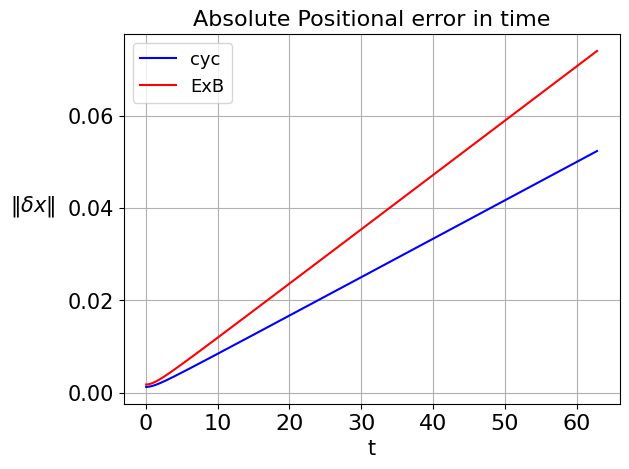

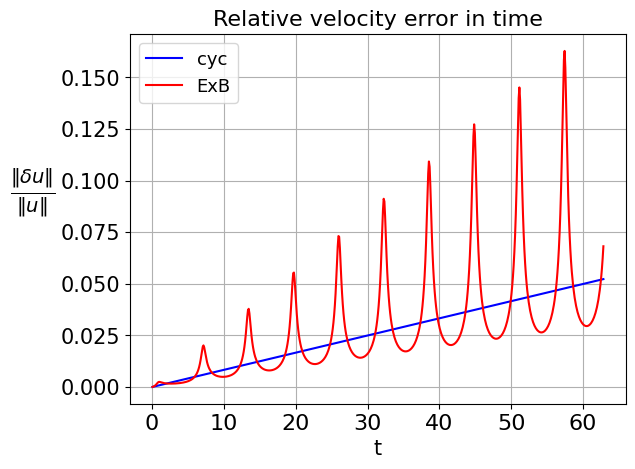

In [15]:
plt.figure()
plt.grid()
plt.plot(times, err_x_cyc, color='b', label='cyc')
plt.plot(times, err_x_ExB, color='r', label='ExB')
plt.xlabel('t')
plt.ylabel(r"$\|\delta x\|$", rotation=0, labelpad=25)
plt.title('Absolute Positional error in time')
plt.legend()
plt.savefig("./img/err_x.pdf", format="pdf", bbox_inches='tight')
plt.show()

plt.figure()
plt.grid()
plt.plot(times, err_v_cyc, color='b', label='cyc')
plt.plot(times,err_v_ExB, color='r', label='ExB')
plt.xlabel('t')
plt.ylabel(r"$\frac{\|\delta u\|}{\|u\|}$", rotation=0, fontsize=20, labelpad=20)
plt.title('Relative velocity error in time')
plt.legend()
plt.savefig("./img/err_v.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Error in time step

In [16]:
q = -1.0
m = 1.0
B0 = 1.0
omega = q*B0/m
T=2*np.pi/abs(omega)
NT = 6
x0 = np.array([1.0, 0.0,0.0])
v0 = np.array([0.0, 1.0, 0.0])

Dt = [np.pi/540, np.pi/180, np.pi/60, np.pi/20, np.pi/6]
err_x_cyc_dt = []
err_v_cyc_dt = []

err_x_ExB_dt = []
err_v_ExB_dt = []


for dt in Dt :

    nsteps = int(NT*T/dt)
    times = np.linspace(dt/2, nsteps*dt + dt/2, nsteps+1, endpoint=True)
    
    x_cyc_num, v_cyc_num = simulate(x0, v0, q, m, times, dt, null_E_field, Bz0)
    x_cyc_an, v_cyc_an = cyclotron_xy(x0, v0, q, m, 1.0, times, dt)

    diff_x_cyc = x_cyc_num - x_cyc_an
    x_cyc_norm_num = np.linalg.norm(x_cyc_num, axis=1)
    err_x_cyc = np.linalg.norm(diff_x_cyc, axis=1)
    err_x_cyc_dt.append(np.max(err_x_cyc))

    diff_v_cyc = v_cyc_num - v_cyc_an
    v_cyc_norm_num = np.linalg.norm(v_cyc_num, axis=1)
    err_v_cyc = np.linalg.norm(diff_v_cyc, axis=1)/v_cyc_norm_num
    err_v_cyc_dt.append(np.max(err_v_cyc))



    x_ExB_num, v_ExB_num = simulate(x0, v0, q, m, times, dt, Ey0, Bz0)
    x_ExB_an, v_ExB_an = ExB_xy(x0=x0, v0=v0, q=q, m=m, E=[0.0, 1.0, 0.0], B=[0.0, 0.0, 1.0], times=times, dt=dt)

    diff_x_ExB = (x_ExB_num - x_ExB_an)
    err_x_ExB = np.linalg.norm(diff_x_ExB, axis=1)
    err_x_ExB_dt.append(np.max(err_x_ExB))

    diff_v_ExB = v_ExB_num - v_ExB_an
    v_ExB_norm_num = np.linalg.norm(v_ExB_num, axis=1)
    err_v_ExB = np.linalg.norm(diff_v_ExB, axis=1)/v_ExB_norm_num
    err_v_ExB_dt.append(np.max(err_v_ExB))

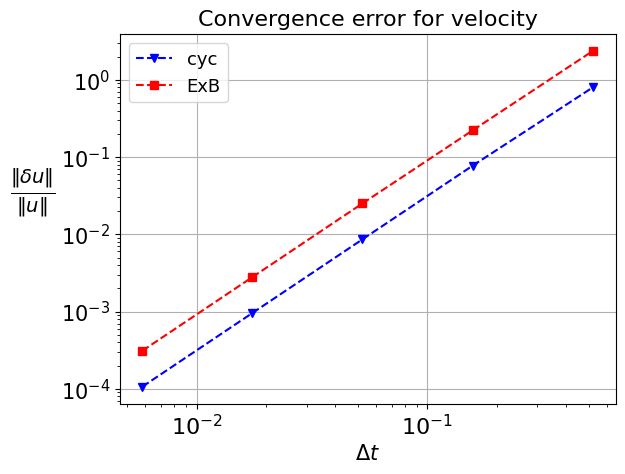

In [17]:
plt.figure()
plt.grid()
plt.xlabel(r"$\Delta t$")
plt.ylabel(r"$\frac{\|\delta u\|}{\|u\|}$", rotation=0, fontsize=20, labelpad=20)
plt.title("Convergence error for velocity")
plt.loglog(Dt, err_v_cyc_dt, 'v--', color='b', label='cyc')
plt.loglog(Dt, err_v_ExB_dt, 's--', color='r', label='ExB')
plt.legend()
plt.savefig("./img/conv_err_v.pdf", format="pdf", bbox_inches='tight')
plt.show()